In [18]:
%reload_ext autoreload
%autoreload 2

import torch
import torchvision
import torchvision.transforms as transforms

from IPython.display import clear_output
import os
from copy import deepcopy

import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import ConvNet, CF10Net
from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import split_data, CustomSubset

torch.manual_seed(42)
np.random.seed(42)

In [19]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='~/data', train=True, download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='~/data', train=False, download=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [20]:
N_CLIENTS = 10
DIRICHLET_ALPHA = 10.0

train_idcs, test_idcs = np.random.permutation(len(trainset)), np.random.permutation(len(testset))
client_idcs = np.arange(0, len(trainset)).reshape(N_CLIENTS, int(len(trainset) / N_CLIENTS))

train_labels = []
for idc in client_idcs:
    for idcc in idc:
        train_labels.append(trainset[idcc][1])
        #print(trainset[idcc][1])
train_labels = np.array(train_labels) 
client_idcs = split_data(train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)
# print(client_idcs)

client_data = [CustomSubset(trainset, idcs) for idcs in client_idcs]
test_data = CustomSubset(testset, test_idcs, transforms.Compose([transforms.ToTensor()]))

#print(client_data[9][4000])

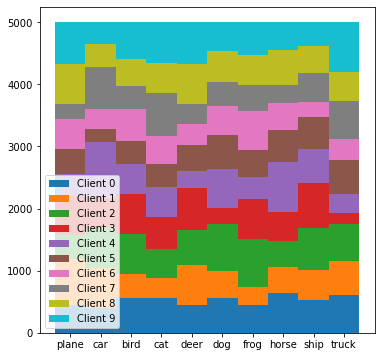

In [21]:

plt.figure(figsize=(6,6))
plt.hist([train_labels[idc]for idc in client_idcs], stacked=True, 
         bins=np.arange(min(train_labels)-0.5, max(train_labels) + 1.5, 1),
        label=["Client {}".format(i) for i in range(N_CLIENTS)])
plt.xticks(np.arange(10), classes)
plt.legend()
plt.show()

In [22]:
clients = [Client(CF10Net, lambda x : torch.optim.SGD(x, lr=0.001, momentum=0.9), dat, idnum=i, leader_id=0) 
           for i, dat in enumerate(client_data)]
server = Server(CF10Net, test_data, testloader)


Client 0:


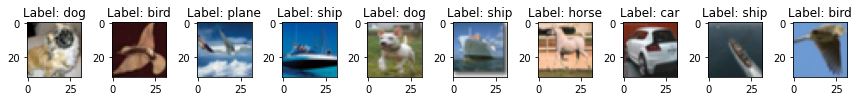

In [23]:
for client in [clients[0]]:
    x, y = iter(client.train_loader).next()

    print("Client {}:".format(client.id))
    plt.figure(figsize=(15,1))
    for i in range(10):
        plt.subplot(1,10,i+1)
#         print(x.shape)
        img = x[i]
        img = img / 2 + 0.5
        plt.imshow(np.transpose(img.numpy(), (1,2,0)))
        plt.title("Label: {}".format(classes[y[i].item()]))
    plt.show()

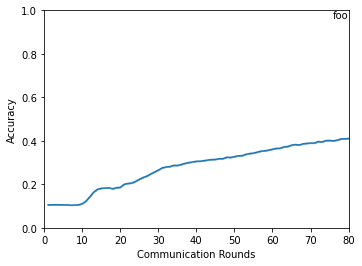

In [24]:
COMMUNICATION_ROUNDS = 80

cfl_stats = ExperimentLogger()

for c_round in range(1, COMMUNICATION_ROUNDS+1):

    print("Round: ", c_round)
        
    # if c_round == 1:
    for client in clients:
        client.synchronize_with_server(server)

    participating_clients = server.select_clients(clients, frac=1.0)
    
    for client in participating_clients:
        print("      Client ", client.id)
        train_stats = client.compute_weight_update(epochs=1)
        client.reset()
        
    server.aggregate_weight_updates(participating_clients)

    acc_server = [server.evaluate()]

    cfl_stats.log({"acc_server" : acc_server, "rounds" : c_round})
       
    display_train_stats(cfl_stats, COMMUNICATION_ROUNDS)


In [25]:
print("Accurary Result: ", acc_server)

Accurary Result:  [0.4109]
